**Getting Started**

This tutorial relies on standard python packages as well as [SimPEG](http://simpeg.xyz). If you do not have SimPEG installed, you can uncomment the next line and install it from [pypi](https://pypi.python.org/pypi/SimPEG).

The second package we are installing is [pymatsolver](https://github.com/rowanc1/pymatsolver), which interfaces to sparse matrix solvers. It is not required for the tutorial, we will fall-back to an LU solver, which is sufficient for this problem 

In [1]:
# !pip install SimPEG
# !pip install pymatsolver

# Inversion: 1D Magnetotelluric Problem

In the previous notebooks, we explored how to discretize the [1D MT problem](./1_MT1D_NumericalSetup.ipynb), how to design an appropriate mesh, and explored the [an example of non-uniquness](./2_MT1D_ForwardModellingAndNonuniqueness.ipynb). In this notebook, we will put those concepts to use and set up a 1D inversion. 

The aim of this notebook is to highlight the elements we use to set up and solve the inverse problem, in the notebook that follows this, we will dive futher into the impact of various parameter choices (eg. the trade-off parameter $\beta$, the stopping criteria, noise model and regulariztion parameters). 

## Inversion as Optimization

We will use deterministic approach and pose the inverse problem as an optimization problem of the form 

$$
\min_{\mathbf{m}} \phi(\mathbf{m}) = \phi_d(\mathbf{m}) + \beta\phi_m(\mathbf{m})
$$

where:
- $\mathbf{m}$ is our model - the vector of numbers that describes our earth model. It is what we are solving for in the inversion
- $\phi_d(\mathbf{m})$ is the data misfit

### Data Misfit

The data misfit, $\phi_d(\mathbf{m})$, is often taken to be a weighted L2-norm, where the weights capture the noise model (eg. we want to assign higher weights and do a good job fitting data that we are confident are less noisy, and assign less weight / influence to data that are noisy). The L2 norm is the correct norm to choose when noise is Gaussian (or approximately Gaussian, or if you have no additional information and assume it is Gaussian). An L2 data misfit is captured mathematically by  

$$
\phi_d(\mathbf{m}) = \frac{1}{2}\|\mathbf{W_d} (\mathcal{F}(\mathbf{m}) - \mathbf{d}^{\text{obs}})\|^2
$$

where 

- $\mathbf{W_d} = \text{diag}(1/\boldsymbol{\epsilon})$ is a diagonal matrix with diagonal entries $1/\epsilon_i$, where $\epsilon_i$ is an estimated standard deviation of the $i$th datum.
- $\mathcal{F}$ is the forward modelling operator that simulates the 1D MT response given a model
- $\mathbf{m}$ is the model: the set of parameters which describe the physical properties of the layered earth
- $\mathbf{d}^{\text{obs}}$ is the observed data

(The factor of $1/2$ and the choice of using the squared-norm is a matter of convienence. We will be using gradient based optimzation methods, so it is easier to take derivatives of a norm squared than a norm.)

### Regularization
The inverse problem is an [ill posed problem](https://en.wikipedia.org/wiki/Well-posed_problem). There are multiple (actually infinitely many!) models that can fit the data.  There are a couple ways to observe this:

- Mathematically: If we start by thinking about a linear problem $\mathbf{G}\mathbf{m} = \mathbf{d}$, the matrix $\mathbf{G}$ is wide, so it is not directly invertible (eg. see Matt Hall's [Linear Inversion Tutorial](http://library.seg.org/doi/full/10.1190/tle35121085.1)). Here, we are dealing with a non-linear system of equations, but the principle is the same. 

- An Example: In the [Forward Modelling and Nonuniqueness notebook](2_MT1D_ForwardModellingAndNonuniqueness.ipynb), we used forward modelling to demonstrate non-uniquness with the conductivity-thickness product of a single, conductive layer, and this is a very simple model compared to most geologic settings! 
Thus, to choose from the infinitely many solutions and arrive at a sensible one, we employ a regularization: $\phi_m$. Tikhonov regularization, which again employs L2-norms, is a standard choice. It takes the form: 
$$
\phi_m(\mathbf{m}) = \frac{1}{2}\big(\alpha_s\|W_s (\mathbf{m} - \mathbf{m}_{\text{ref}})\|^2 + \alpha_z\|W_z (\mathbf{m})\|^2 \big)
$$

Nice features:
- convex
- easy to differentiate
- results in smooth models


## In this notebook...

Although we pose the inverse problem as an optimization problem, we aren't necessarily going to solve to a true minimum. There are always uncertainties with the data, so there is no point trying to drive $\phi_d$ to its true minimium - we would end up introducing structures in the model to fit the data (we will explore this here). So another choice that has to be made when setting up an inversion is where to stop. 

In this notebook, we will walk through how to set up an inversion, discuss concepts including:
- **Tikhonov curve**: a plot of $\phi_d$ vs $\phi_m$
- Defining a **target misfit** as a stopping criteria: $\phi_d^*$ and exploring what happens when we overfit or underfit the data
- Tuning the **regularization** ($\alpha_s$, $\alpha_z$): how _smooth_ or _small_ (in the L2-sense) do we want our model to be?

We will employ second-order optimization methods, meaning we have to be able to both simulate data and compute derivatives. We will take those steps for granted in this notebook, but if you are curious to look under the hood ans see how sensitivities are computed for this problem, have a look at the [Sensitivities Notebook](MT1D_Sensitivity.ipynb).  

In [27]:
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt

from SimPEG import (
    Mesh, Maps, SolverLU, DataMisfit, Regularization,
    Optimization, InvProblem, Inversion, Directives, Utils
)

try:
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as Solver
    
from MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
%matplotlib inline

In [28]:
rxloc = np.r_[0.]
srcloc = np.r_[0.]

frequency = np.logspace(-3, 2, 25)
rxType = "AppredPha"
if rxType == "Zxy":
    rx = ZxyRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
elif rxType == "AppredPha":
    rx = AppResPhaRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
src = MT1DSrc(rxList, loc=srcloc)
survey = MT1DSurvey([src])
max_depth_core = 5000.
mesh = survey.setMesh(
        sigma=0.01, max_depth_core=max_depth_core, ncell_per_skind=10, n_skind=2,
        core_meshType = "linear", max_hz_core=1000.
                     )
sigma = np.ones(mesh.nC) * 0.01
prob = MT1DProblem(mesh, sigmaMap=Maps.ExpMap(mesh), verbose=False, Solver=Solver)
prob.pair(survey)

>> Smallest cell size = 50 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 100


In [29]:
rho_half = 100.
rho_target = 10.
depth = 2000.
thickness = 1000.
layer_inds = np.logical_and(mesh.vectorCCx<-depth, mesh.vectorCCx>-depth-thickness)
sigma = np.ones(mesh.nC) * 1./rho_half
sigma[layer_inds] = 1./rho_target
actinds = mesh.vectorCCx > -max_depth_core


mtrue = np.log(sigma)
dtrue = survey.dpred(mtrue)
np.random.seed(1)
std_appres = 0.05
floor_phase = 2.
uncert = (np.c_[abs(dtrue.reshape((survey.nFreq, 2)))[:,0]*std_appres, np.ones(survey.nFreq)*floor_phase]).flatten()
noise = uncert * np.random.randn(survey.nFreq*2)
survey.dobs = dtrue + noise

(0, 5000.0)

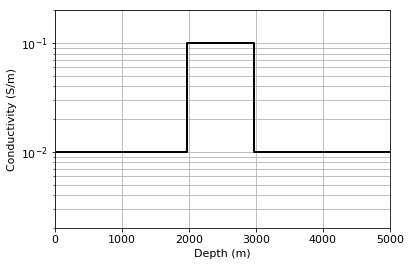

In [30]:
import matplotlib
matplotlib.rcParams["font.size"] = 11
# figsize(5, 2)
sigtrue = np.repeat(sigma, 2, axis=0)
z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
plt.plot(-z, sigtrue, 'k', lw=2)
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Conductivity (S/m)")
plt.xlabel("Depth (m)")
plt.grid(True, which='both')
plt.ylim(2e-3, 2e-1)
plt.xlim(0, max_depth_core)

In [31]:
app_res = dtrue.reshape((survey.nFreq, 2))[:,0]
phase = dtrue.reshape((survey.nFreq, 2))[:,1]

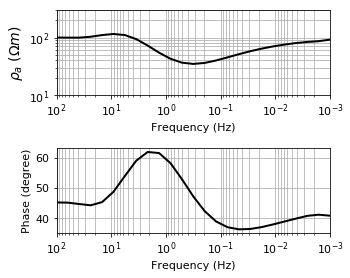

In [32]:
fig = plt.figure(figsize = (5, 4))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.loglog(frequency, app_res, 'k-', lw=2)
ax1.grid(True, which='both')
ax1.set_xlim(frequency.max(), frequency.min())
ax1.set_ylim(10, 3e2)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

ax2.semilogx(frequency, phase, 'k-', lw=2)
ax2.grid(True, which='both')
ax2.set_xlim(frequency.max(), frequency.min())
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Phase (degree)")
plt.tight_layout()

In [33]:
# dtrue.reshape((survey.nFreq, 2))

In [57]:
def run_MT1Dinv(prob, survey, m0,
                std_appres=0.05, floor_phase =2.,
                alpha_s=1., alpha_x=1., coolingFactor=2., coolingRate=1, 
                beta0=1e1, beta0_ratio=None,
                use_betaest=False, use_target=True):
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert
    reg = Regularization.Tikhonov(prob.mesh, alpha_s=alpha_s, alpha_x=alpha_x)
    opt = Optimization.InexactGaussNewton(maxIter=35, LSshorten=0.05)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    # Create an inversion object
    beta = Directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    invProb.beta = beta0
    target = Directives.TargetMisfit()
    save = Directives.SaveOutputEveryIteration()
    directs = [beta, save]

    if use_target:
        directs.append(target)
    if use_betaest:
        if beta0_ratio is None:
            beta0_ratio = 1.
        betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
        directs.append(betaest)      
        

    inv = Inversion.BaseInversion(invProb, directiveList=directs)
    prob.counter = opt.counter = Utils.Counter()
    opt.remember('xc')
    mopt = inv.run(m0)
    xc = opt.recall("xc")
    return xc, save, reg



In [58]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc, save, reg = run_MT1Dinv(prob, survey, m0, 
                            alpha_s=1., alpha_x=1e6,
                            use_target=False)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-13-18-28.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+01  3.84e+03  0.00e+00  3.84e+03    1.34e+03      0              
   1  6.67e+00  2.61e+03  5.31e+01  2.96e+03    2.54e+02      0              
   2  4.44e+00  2.32e+03  8.92e+01  2.72e+03    2.63e+02      0   Skip BFGS  
   3  2.96e+00  1.99e+03  1.50e+02  2.44e+03    2.22e+02      0   Skip BFGS  
   4  1.98e+00  1.68e+03  2.38e+02  2

In [59]:
header = " iter    beta     phi_d     phi_m  phi_m_smalll phi_m_smooth_x   phi_m_smooth_y  phi_m_smooth_z  f "
header = header.split()
results = np.loadtxt(save.fileName+str(".txt"), comments="#")
beta = results[:,1]
phi_d = results[:,2]
phi_m = results[:,3]

target_misfit = 2 * survey.nFreq / 2.
i_target = 0
while phi_d[i_target] > target_misfit:
    i_target += 1    

IndexError: index 5 is out of bounds for axis 1 with size 5

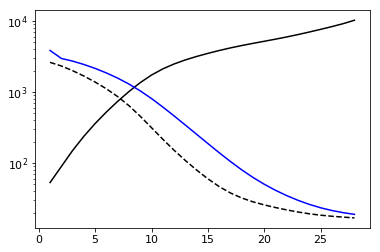

In [60]:
plt.semilogy(results[:,0], results[:,2], 'k--')
plt.semilogy(results[:,0], results[:,3], 'k')
plt.semilogy(results[:,0], results[:,4], 'b')
plt.semilogy(results[:,0], results[:,5], 'r')
# plt.legend(
#     ("$\phi_d$","$\phi_m$", "small", "smooth"), 
#     fontsize = 10, loc=4
# )
plt.xlabel("Iteration")
plt.ylabel("Objective function")

In [ ]:
fig = plt.figure(figsize = (5, 8))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.plot(beta, phi_d, 'k-', lw=2, ms=4)
ax1.plot(beta[i_target], phi_d[i_target], 'k*', ms=10)
ax1.set_xlim(beta.min(), beta.max())
ax1.set_xlabel("$\\beta$", fontsize = 14)
ax1.set_ylabel("$\phi_d$", fontsize = 14)

ax2.plot(beta, phi_m, 'k-', lw=2)
ax2.plot(beta[i_target], phi_m[i_target], 'k*', ms=10)
ax2.set_xlim(beta.min(), beta.max())
ax2.set_xlabel("$\\beta$", fontsize = 14)
ax2.set_ylabel("$\phi_m$", fontsize = 14)

ax3.plot(phi_m, phi_d, 'k-', lw=2)
ax3.plot(phi_m[i_target], phi_d[i_target], 'k*', ms=10)
ax3.set_xlim(phi_m.min(), phi_m.max())
ax3.set_xlabel("$\phi_m$", fontsize = 14)
ax3.set_ylabel("$\phi_d$", fontsize = 14)
for ax in [ax1, ax2, ax3]:
    ax.set_xscale("log")
    ax.set_yscale("log")    
plt.tight_layout()

In [61]:
app_res = survey.dobs.reshape((survey.nFreq, 2))[:,0]
phase = survey.dobs.reshape((survey.nFreq, 2))[:,1]

In [62]:
from ipywidgets import interact, IntSlider, ToggleButtons

In [63]:
def view_1Dinversion_results(iteration, scale):
    fig = plt.figure(figsize = (10, 5))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.loglog(phi_m, phi_d, 'k-', lw=2)
    ax1.loglog(phi_m[i_target], phi_d[i_target], 'k*', ms=10)
    ax1.loglog(phi_m[iteration], phi_d[iteration], 'ro', ms=10)
    ax1.set_xlim(phi_m.min(), phi_m.max())
    ax1.set_xlabel("$\phi_m$", fontsize = 14)
    ax1.set_ylabel("$\phi_d$", fontsize = 14)
    ax1.set_xscale(scale)
    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax3.plot(-z, sigtrue, 'k', lw=2)
    ax3.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax3.set_xscale("linear")
    ax3.set_yscale("log")
    ax3.set_ylabel("Conductivity (S/m)")
    ax3.set_xlabel("Depth (m)")
    ax3.grid(True, which='both')
    ax3.set_ylim(2e-3, 2e-1)
    ax3.set_xlim((-z).min(), max_depth_core)

    dpred = survey.dpred(xc[iteration])
    app_res_pred = dpred.reshape((survey.nFreq, 2))[:,0]
    phase_pred = dpred.reshape((survey.nFreq, 2))[:,1]
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax4.semilogx(frequency, phase, 'k-', lw=2)
    ax4.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax4.grid(True, which='both')
    ax4.set_xlim(frequency.max(), frequency.min())
    ax4.set_xlabel("Frequency (Hz)")
    ax4.set_ylabel("Phase (degree)")
    plt.tight_layout()
    plt.show()
    
interact(view_1Dinversion_results, 
         iteration=IntSlider(min=0, max=results.shape[0]-1, step=1, value=0),
         scale=ToggleButtons(options=["linear", "log"], value="log"))

<function __main__.view_1Dinversion_results>

In [51]:
def MT1D_inv_results(xc, iteration):
    fig = plt.figure(figsize = (5, 7))
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax1.plot(-z, sigtrue, 'k', lw=2)
    ax1.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax1.set_xscale("linear")
    ax1.set_yscale("log")
    ax1.set_ylabel("Conductivity (S/m)")
    ax1.set_xlabel("Depth (m)")
    ax1.grid(True, which='both')
    ax1.set_ylim(2e-3, 4e-1)
    ax1.set_xlim((-z).min(), max_depth_core)

    dpred = survey.dpred(xc[iteration])
    app_res_pred = dpred.reshape((survey.nFreq, 2))[:,0]
    phase_pred = dpred.reshape((survey.nFreq, 2))[:,1]
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax3.semilogx(frequency, phase, 'k-', lw=2)
    ax3.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax3.grid(True, which='both')
    ax3.set_xlim(frequency.max(), frequency.min())
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("$\phi \ (^{\circ})$", fontsize = 14)
    plt.tight_layout()

In [52]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc_fixed, save_fixed, reg = run_MT1Dinv(prob, survey, m0,
                                   beta0=beta[i_target]*10, coolingFactor=2., coolingRate=3,
                                   alpha_s=1., alpha_x=1.,
                                   use_target=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-13-18-27.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e-02  3.84e+03  0.00e+00  3.84e+03    1.34e+03      0              
   1  1.34e-02  2.35e+02  2.29e+03  2.66e+02    1.13e+02      0              
   2  8.91e-03  3.50e+01  3.09e+03  6.25e+01    4.33e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.8453e+02


In [53]:
smooth = reg.objfcts[1]

In [54]:
reg.regmesh

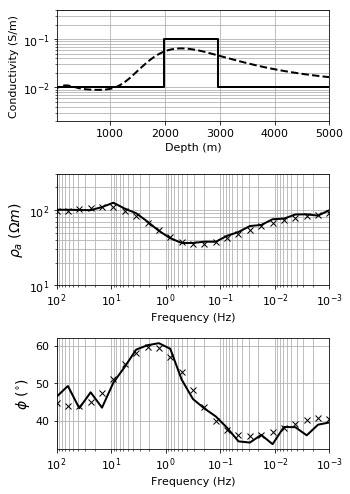

In [55]:
MT1D_inv_results(xc_fixed, -1)

In [56]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc_fixed, save_fixed, reg = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=2., coolingRate=3,
                                   alpha_s=1., alpha_x=0., beta0 = beta[i_target]*10,
                                   use_target=True, use_betaest=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-13-18-27.txt'


KeyboardInterrupt: 

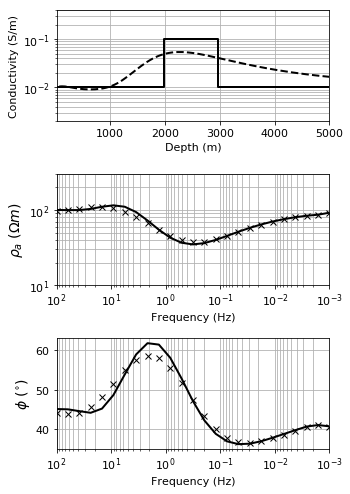

In [23]:
MT1D_inv_results(xc_fixed, -1)

In [24]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc_fixed, save_fixed, reg = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=2., coolingRate=3,
                                   alpha_s=0., alpha_x=1., beta0 = beta[i_target]*10,
                                   use_target=True, use_betaest=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-12-23-57.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.45e+04  3.84e+03  0.00e+00  3.84e+03    1.34e+03      0              
   1  1.63e+04  6.17e+02  7.32e-05  6.19e+02    1.91e+02      0              
   2  1.09e+04  2.73e+02  2.42e-04  2.76e+02    1.17e+02      0   Skip BFGS  
   3  7.25e+03  1.54e+02  5.35e-04  1.58e+02    5.58e+01      0   Skip BFGS  
   4  4.83e+03  1.41e+02  5.17e-04  1

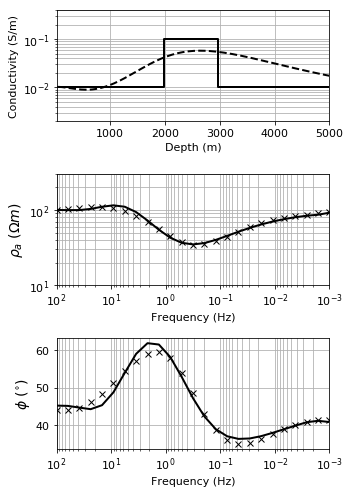

In [25]:
MT1D_inv_results(xc_fixed, -1)